# 1. Import Modules

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dataframe_image as dfi
import shap

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder 

from mlxtend.plotting import plot_confusion_matrix

from ydata_profiling import ProfileReport

# 2. Import the Data

In [3]:
df = pd.read_csv('Telco_Customer_Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
# Drop the customerID

df.drop(['customerID'], axis = 1, inplace = True)
df.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

# 3. Utility Functions

In [6]:
def return_categorical(df):

    categorical_columns = [column_name for column_name in df if df[column_name].dtype == 'O']
    return categorical_columns

def check_unique_values(columns):
    for i in columns:
        print("Column name :", i,'\n', df[i].unique())
        print()

# 4. Explanatory Data Analysis

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [8]:
df.describe(include = "object").T

count unique               top  freq
gender            7043      2              Male  3555
Partner           7043      2                No  3641
Dependents        7043      2                No  4933
PhoneService      7043      2               Yes  6361
MultipleLines     7043      3                No  3390
InternetService   7043      3       Fiber optic  3096
OnlineSecurity    7043      3                No  3498
OnlineBackup      7043      3                No  3088
DeviceProtection  7043      3                No  3095
TechSupport       7043      3                No  3473
StreamingTV       7043      3                No  2810
StreamingMovies   7043      3                No  2785
Contract          7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
TotalCharges      7043   6531                      11
Churn             7043      2                No  5174

In [9]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Look at the datatypes. If there are objects, then look at the unique values
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [11]:
# As seen, we can convert TotalCharges column to numeric because there are empty strings (missing data)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

ValueError: Unable to parse string " " at position 488

In [12]:
# We need to look at how many empty strings there are in TotalCharges column
len(df.loc[df['TotalCharges'] == ' '])

11

In [13]:
# Total Charges is missing for some customers because they just signed up so we can set them to 0.
df.loc[df['TotalCharges'] == ' ']

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
488   Bank transfer (automatic)           52.55                 No  
753                Mailed check           20.25                 No  
936                Mailed check           80.85                 No  
1082               Mailed check           25.75                 No  
1340    Credit card (automatic)           56.05                 No  
3331               Mailed check           19.85                 No  
3826               Mailed check           25.35                 No  
4380               Mailed check           20.00                 No

In [14]:
# Set them to 0
df.loc[(df['TotalCharges'] == ' '), 'TotalCharges'] = 0

In [15]:
# Check if we correctly can set them to 0

df.loc[df['tenure'] == 0]

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
488   Bank transfer (automatic)           52.55            0    No  
753                Mailed check           20.25            0    No  
936                Mailed check           80.85            0    No  
1082               Mailed check           25.75            0    No  
1340    Credit card (automatic)           56.05            0    No  
3331               Mailed check           19.85            0    No  
3826               Mailed check           25.35            0    No  
4380               Mailed check           20.00            0    No

In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [17]:
# SeniorCitizen should be a categorical feature
df.loc[(df['SeniorCitizen'] == 0), 'SeniorCitizen'] = 'No'
df.loc[(df['SeniorCitizen'] == 1), 'SeniorCitizen'] = 'Yes'

In [18]:
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [19]:
# Check the unique values in each categorical features
check_unique_values(return_categorical(df))

Column name : gender 
 ['Female' 'Male']

Column name : SeniorCitizen 
 ['No' 'Yes']

Column name : Partner 
 ['Yes' 'No']

Column name : Dependents 
 ['No' 'Yes']

Column name : PhoneService 
 ['No' 'Yes']

Column name : MultipleLines 
 ['No phone service' 'No' 'Yes']

Column name : InternetService 
 ['DSL' 'Fiber optic' 'No']

Column name : OnlineSecurity 
 ['No' 'Yes' 'No internet service']

Column name : OnlineBackup 
 ['Yes' 'No' 'No internet service']

Column name : DeviceProtection 
 ['No' 'Yes' 'No internet service']

Column name : TechSupport 
 ['No' 'Yes' 'No internet service']

Column name : StreamingTV 
 ['No' 'Yes' 'No internet service']

Column name : StreamingMovies 
 ['No' 'Yes' 'No internet service']

Column name : Contract 
 ['Month-to-month' 'One year' 'Two year']

Column name : PaperlessBilling 
 ['Yes' 'No']

Column name : PaymentMethod 
 ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Column name : Churn 
 ['No' 'Yes']



In [19]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 5.1 Format the Data: Split into Features and Target 

In [20]:
# Label Encoding for target variable

le = LabelEncoder()
df['Churn']= le.fit_transform(df['Churn'])
df.head()

gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female            No     Yes         No       1           No   
1    Male            No      No         No      34          Yes   
2    Male            No      No         No       2          Yes   
3    Male            No      No         No      45           No   
4  Female            No      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

   Churn  
0      0  
1      0  
2      1  
3      0  
4      1

In [21]:
df['Churn'].unique()

array([0, 1])

In [22]:
X = df.drop(['Churn'], axis = 1).copy()
X.head()

gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female            No     Yes         No       1           No   
1    Male            No      No         No      34          Yes   
2    Male            No      No         No       2          Yes   
3    Male            No      No         No      45           No   
4  Female            No      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  
0              Yes           Electronic check           29.85         29.85  
1               No               Mailed check           56.95       1889.50  
2              Yes               Mailed check           53.85        108.15  
3               No  Bank transfer (automatic)           42.30       1840.75  
4              Yes           Electronic check           70.70        151.65

In [23]:
y = df['Churn'].copy()
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int32

# 5.2 Formatting the Data : One-Hot Encoding for Categorical Features

In [24]:
X_encoded = pd.get_dummies(X, columns = return_categorical(X))

X_encoded.head()

tenure  MonthlyCharges  TotalCharges  gender_Female  gender_Male  \
0       1           29.85         29.85              1            0   
1      34           56.95       1889.50              0            1   
2       2           53.85        108.15              0            1   
3      45           42.30       1840.75              0            1   
4       2           70.70        151.65              1            0   

   SeniorCitizen_No  SeniorCitizen_Yes  Partner_No  Partner_Yes  \
0                 1                  0           0            1   
1                 1                  0           1            0   
2                 1                  0           1            0   
3                 1                  0           1            0   
4                 1                  0           1            0   

   Dependents_No  ...  StreamingMovies_Yes  Contract_Month-to-month  \
0              1  ...                    0                        1   
1              1  ...                    0                        0   
2              1  ...                    0                        1   
3              1  ...                    0                        0   
4              1  ...                    0                        1   

   Contract_One year  Contract_Two year  PaperlessBilling_No  \
0                  0                  0                    0   
1                  1                  0                    1   
2                  0                  0                    0   
3                  1                  0                    1   
4                  0                  0                    0   

   PaperlessBilling_Yes  PaymentMethod_Bank transfer (automatic)  \
0                     1                                        0   
1                     0                                        0   
2                     1                                        0   
3                     0                                        1   
4                     1                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 46 columns]

# 5.Preliminary XGBoost Model

In [25]:
# Train- Test Splits. Stratified Sampling

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify = y)

In [26]:
# Create validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

In [27]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4507, 46)
y_train shape: (4507,)
X_val shape:(1127, 46)
y_val shape: (1127,)
X_test shape:(1409, 46)
y_test shape: (1409,)


In [28]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_val:', np.bincount(y_val))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [5174 1869]
Labels counts in y_train: [3311 1196]
Labels counts in y_val: [828 299]
Labels counts in y_test: [1035  374]


In [29]:
# As seen, the ratio is same for train, validation, and test sets
print(f"Ratio in train data: {sum(y_train) / len(y_train)*100:0.2f}")
print(f"Ratio in valid data: {sum(y_val) / len(y_val)*100:0.2f}")
print(f"Ratio in test data: {sum(y_test) / len(y_test)*100:0.2f}")

Ratio in train data: 26.54
Ratio in valid data: 26.53
Ratio in test data: 26.54


In [29]:
clf_xgb = XGBClassifier(objective = 'binary:logistic',
                        eval_metric = 'auc',
                        seed = 42)
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set = [(X_val,y_val)])

[0]	validation_0-auc:0.82219
[1]	validation_0-auc:0.83804
[2]	validation_0-auc:0.84045
[3]	validation_0-auc:0.84204
[4]	validation_0-auc:0.84295
[5]	validation_0-auc:0.84030
[6]	validation_0-auc:0.84152
[7]	validation_0-auc:0.84196
[8]	validation_0-auc:0.84169
[9]	validation_0-auc:0.84053
[10]	validation_0-auc:0.84092
[11]	validation_0-auc:0.84181
[12]	validation_0-auc:0.84214
[13]	validation_0-auc:0.84217
[14]	validation_0-auc:0.84108
[15]	validation_0-auc:0.84092
[16]	validation_0-auc:0.83978
[17]	validation_0-auc:0.83921
[18]	validation_0-auc:0.83846
[19]	validation_0-auc:0.83889
[20]	validation_0-auc:0.83977
[21]	validation_0-auc:0.84007
[22]	validation_0-auc:0.84147
[23]	validation_0-auc:0.84087
[24]	validation_0-auc:0.84075
[25]	validation_0-auc:0.83978
[26]	validation_0-auc:0.83778
[27]	validation_0-auc:0.83759
[28]	validation_0-auc:0.83778
[29]	validation_0-auc:0.83698
[30]	validation_0-auc:0.83712
[31]	validation_0-auc:0.83715
[32]	validation_0-auc:0.83705
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

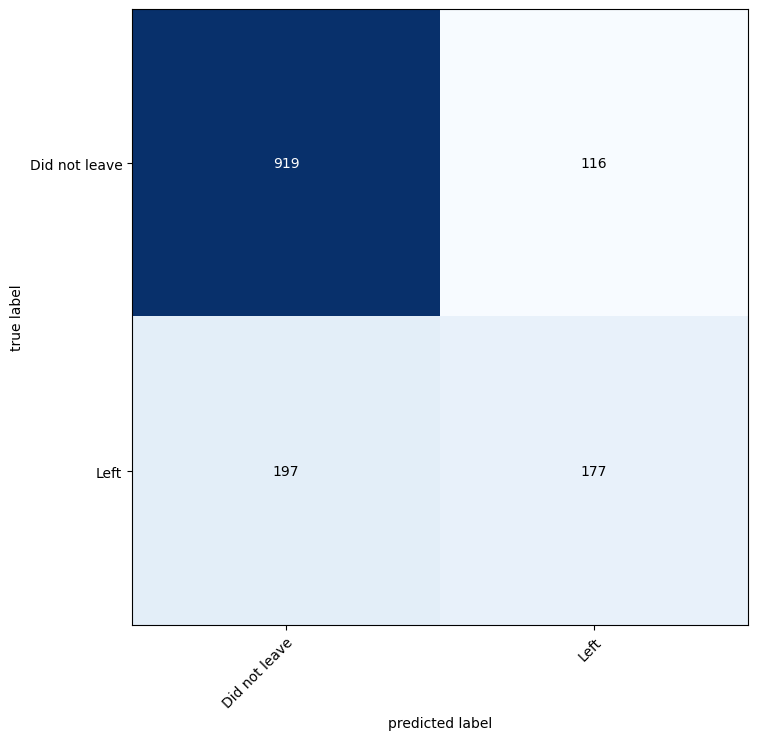

In [30]:
# Confusion Matrix
%matplotlib inline
y_pred = clf_xgb.predict(X_test)
labels = ['Did not leave','Left' ]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize=(8, 8), class_names=labels)
plt.show()

In [31]:
# We can see that the model detects only 47% percent of customer who left. We cannot afford to lose customer so 
# we should increase this percentage using hyperparameter tuning
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

Did not leave       0.82      0.89      0.85      1035
         Left       0.60      0.47      0.53       374

     accuracy                           0.78      1409
    macro avg       0.71      0.68      0.69      1409
 weighted avg       0.77      0.78      0.77      1409



# 6.RandomizedSearchCV for hyperparameter tuning for XGBoost Model

In [68]:
params = {'n_estimators'  : [100,200,500,1000,5000],
          'learning_rate' : [0.001,0.01,0.05, 0.1, 0.2, 0.3],
          'max_depth' : range(3,10,1),
          'gamma' : [0, 0.25, 1.0, 2.0, 2.5],
          'reg_lambda' : [0, 1.0, 10.0, 20.0],
          'reg_alpha' : [0, 1.0, 10.0, 20.0],
          'scale_pos_weight' : [1, 3, 3.5, 4, 5],
          'subsample' : [0.5,0.7,0.8],
         }


estimator = XGBClassifier(objective = 'binary:logistic',seed = 42)

random_cv = RandomizedSearchCV(estimator = estimator, param_distributions = params, scoring = 'roc_auc', cv = 5, n_iter = 30)
random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=30,
                   param_distributions={'gamma': [0, 0.25, 1.0, 2.0, 2.5],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': range(3, 10),
                                        'n_estimators': [100, 200, 500, 1000,
                                                         5000],
                                        'reg_alpha': [0, 1.0, 10.0, 20.0],
                                        'reg_lambda': [0, 1.0, 10.0, 20.0],
                                        'scale_pos_weight': [1, 3, 3.5, 4, 5],
                                        'subsample': [0.5, 0.7, 0.8]},
                   scoring='roc_auc')

In [69]:
random_cv.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 3.5,
 'reg_lambda': 20.0,
 'reg_alpha': 20.0,
 'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.2,
 'gamma': 2.5}

In [75]:
#Tuned Model

clf_xgb_tuned = XGBClassifier(
                        n_estimators = random_cv.best_params_['n_estimators'],
                        max_depth = random_cv.best_params_['max_depth'],
                        learning_rate = random_cv.best_params_['learning_rate'],
                        objective = 'binary:logistic',
                        booster = 'gbtree',
                        gamma = random_cv.best_params_['gamma'],
                        subsample = random_cv.best_params_['subsample'],
                        reg_alpha = random_cv.best_params_['reg_alpha'],
                        reg_lambda = random_cv.best_params_['reg_lambda'],
                        scale_pos_weight = random_cv.best_params_['scale_pos_weight'],
                        eval_metric = 'auc',
                        early_stopping_rounds = 10,
                        seed = 42)


clf_xgb_tuned.fit(X_train,
                  y_train,
                  verbose = True,
                  eval_set = [(X_val,y_val)])

[0]	validation_0-auc:0.80176
[1]	validation_0-auc:0.81939
[2]	validation_0-auc:0.83089
[3]	validation_0-auc:0.83709
[4]	validation_0-auc:0.83424
[5]	validation_0-auc:0.83579
[6]	validation_0-auc:0.83924
[7]	validation_0-auc:0.84061
[8]	validation_0-auc:0.84447
[9]	validation_0-auc:0.84566
[10]	validation_0-auc:0.84885
[11]	validation_0-auc:0.84983
[12]	validation_0-auc:0.85126
[13]	validation_0-auc:0.85088
[14]	validation_0-auc:0.85138
[15]	validation_0-auc:0.85115
[16]	validation_0-auc:0.85101
[17]	validation_0-auc:0.85086
[18]	validation_0-auc:0.85177
[19]	validation_0-auc:0.85270
[20]	validation_0-auc:0.85316
[21]	validation_0-auc:0.85284
[22]	validation_0-auc:0.85276
[23]	validation_0-auc:0.85365
[24]	validation_0-auc:0.85359
[25]	validation_0-auc:0.85327
[26]	validation_0-auc:0.85284
[27]	validation_0-auc:0.85270
[28]	validation_0-auc:0.85293
[29]	validation_0-auc:0.85334
[30]	validation_0-auc:0.85363
[31]	validation_0-auc:0.85322
[32]	validation_0-auc:0.85322
[33]	validation_0-au

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

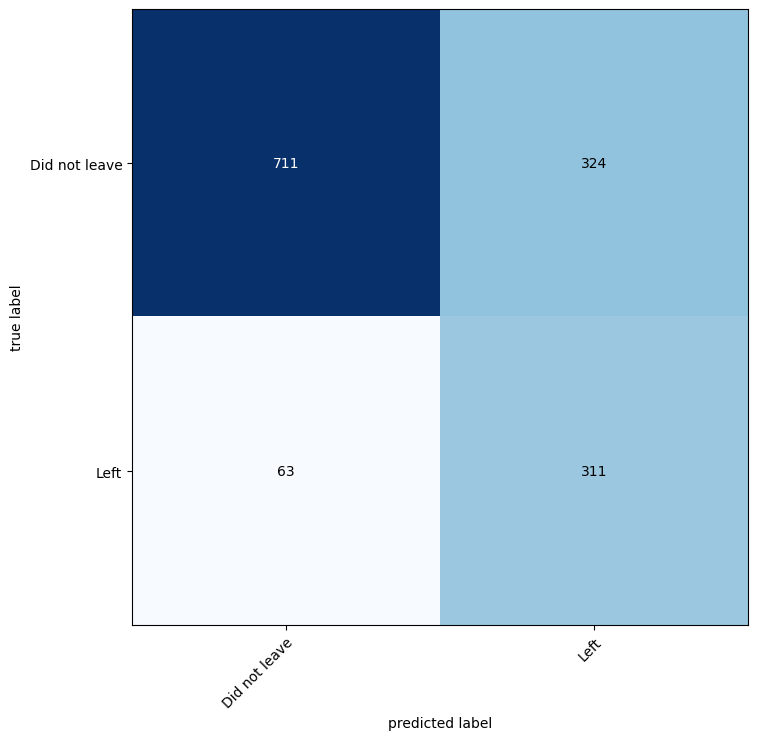

In [76]:
# Confusion Matrix
%matplotlib inline
y_pred_xgb = clf_xgb_tuned.predict(X_test)
labels = ['Did not leave','Left' ]
cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cm, figsize=(8, 8), class_names=labels)
plt.show()

In [79]:
# We observe that the model successfully identifies 83% of the customers who have left.
# Also, FPR = 1-0.69 = 0.31. The model flags 31% of customers, who have not actually left, as having left.
# In this model. we prefer to increase TPR (from 0.47 to 0.83) because we cannot afford to lose customer.

print(classification_report(y_test, y_pred_xgb, target_names=labels))

               precision    recall  f1-score   support

Did not leave       0.92      0.69      0.79      1035
         Left       0.49      0.83      0.62       374

     accuracy                           0.73      1409
    macro avg       0.70      0.76      0.70      1409
 weighted avg       0.80      0.73      0.74      1409



# 7. Preliminary LightGBM Model

In [80]:
clf_lgb = LGBMClassifier(objective = 'binary',
                        seed = 42)
clf_lgb.fit(X_train,
            y_train,
            eval_metric = 'auc',
            eval_set = [(X_val,y_val)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265365 -> initscore=-1.018268
[LightGBM] [Info] Start training from score -1.018268


LGBMClassifier(objective='binary', seed=42)

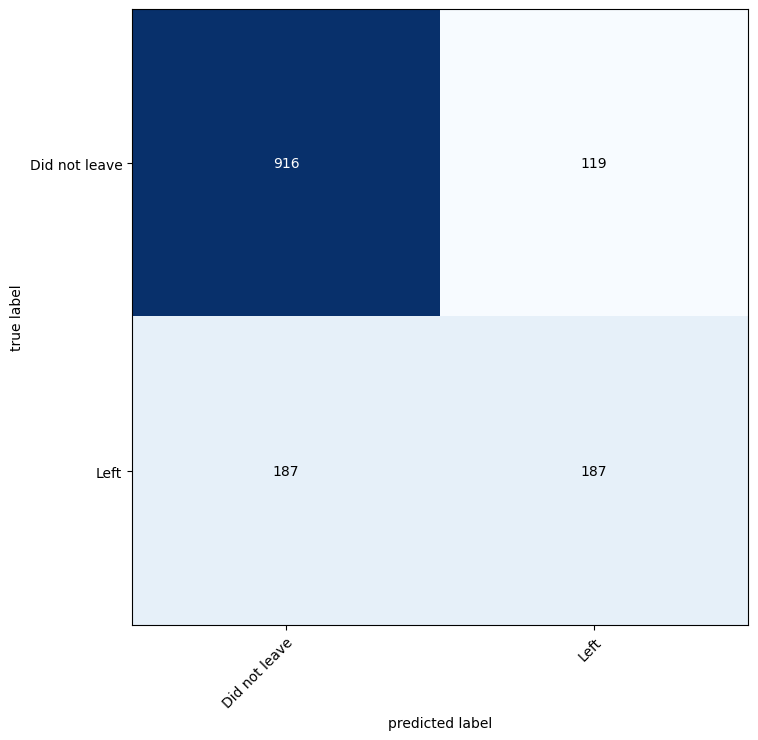

In [81]:
# Confusion Matrix
%matplotlib inline
y_pred_lgb = clf_lgb.predict(X_test)
labels = ['Did not leave','Left' ]
cm = confusion_matrix(y_test, y_pred_lgb)
plot_confusion_matrix(cm, figsize=(8, 8), class_names=labels)
plt.show()

In [83]:
# We can see that the model detects only 50% percent of customer who left. We cannot afford to lose customer so 
# we should increase this percentage using hyperparameter tuning

print(classification_report(y_test, y_pred_lgb, target_names=labels))

               precision    recall  f1-score   support

Did not leave       0.83      0.89      0.86      1035
         Left       0.61      0.50      0.55       374

     accuracy                           0.78      1409
    macro avg       0.72      0.69      0.70      1409
 weighted avg       0.77      0.78      0.78      1409



# 8.RandomizedSearchCV for hyperparameter tuning for LightGBM Model

In [88]:
params = {'n_estimators'  : [100,200,500,1000,5000],
          'learning_rate' : [0.01, 0.05, 0.08, 0.1],
          'max_depth' : [5,6,8, 10, 15, 20],
          'reg_lambda' : [0, 1.0, 10.0, 20.0],
          'reg_alpha' : [0, 1.0, 10.0, 20.0],
          'scale_pos_weight' : [1, 3, 3.5, 4, 5],
          'subsample' : [0.5,0.7,0.8],
         }


estimator = LGBMClassifier(objective = 'binary',seed = 42, verbose = -1)

random_cv_lgb = RandomizedSearchCV(estimator = estimator, param_distributions = params, scoring = 'roc_auc', cv = 5, n_iter = 20)
random_cv_lgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary', seed=42,
                                            verbose=-1),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.08,
                                                          0.1],
                                        'max_depth': [5, 6, 8, 10, 15, 20],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         5000],
                                        'reg_alpha': [0, 1.0, 10.0, 20.0],
                                        'reg_lambda': [0, 1.0, 10.0, 20.0],
                                        'scale_pos_weight': [1, 3, 3.5, 4, 5],
                                        'subsample': [0.5, 0.7, 0.8]},
                   scoring='roc_auc')

In [89]:
random_cv_lgb.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 3,
 'reg_lambda': 1.0,
 'reg_alpha': 20.0,
 'n_estimators': 1000,
 'max_depth': 8,
 'learning_rate': 0.08}

In [90]:
clf_lgb_tuned = LGBMClassifier(
                        n_estimators = random_cv_lgb.best_params_['n_estimators'],
                        max_depth = random_cv_lgb.best_params_['max_depth'],
                        learning_rate = random_cv_lgb.best_params_['learning_rate'],
                        objective = 'binary',
                        subsample = random_cv_lgb.best_params_['subsample'],
                        reg_alpha = random_cv_lgb.best_params_['reg_alpha'],
                        reg_lambda = random_cv_lgb.best_params_['reg_lambda'],
                        scale_pos_weight = random_cv_lgb.best_params_['scale_pos_weight'],
                        verbose = -1,
                        seed = 42)
clf_lgb_tuned.fit(X_train,
                  y_train,
                  eval_metric = 'auc',
                  eval_set = [(X_val,y_val)])

LGBMClassifier(learning_rate=0.08, max_depth=8, n_estimators=1000,
               objective='binary', reg_alpha=20.0, reg_lambda=1.0,
               scale_pos_weight=3, seed=42, subsample=0.5, verbose=-1)

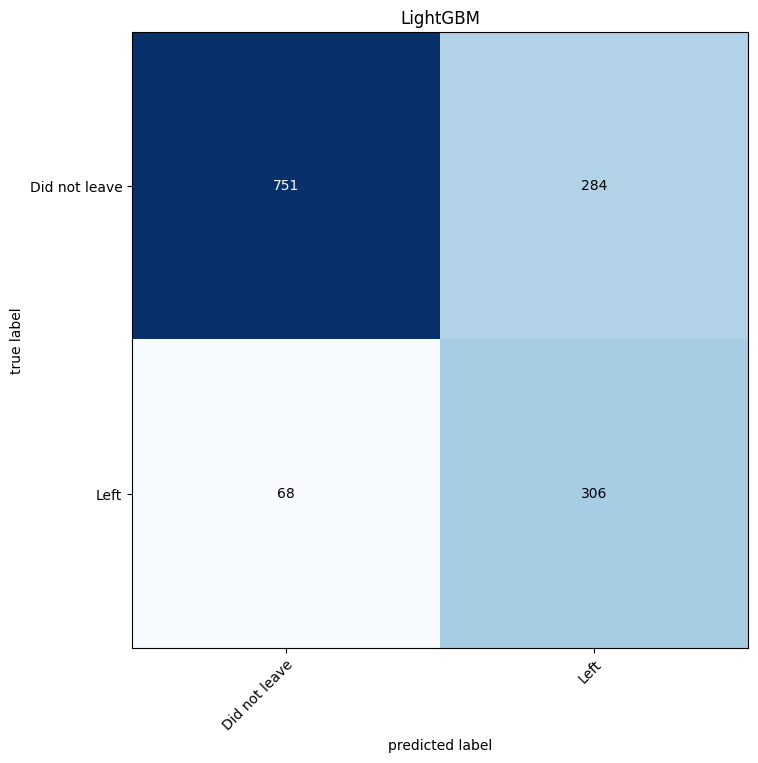

In [239]:
# Confusion Matrix
%matplotlib inline
y_pred_lgb = clf_lgb_tuned.predict(X_test)
labels = ['Did not leave','Left' ]
cm = confusion_matrix(y_test, y_pred_lgb)
plot_confusion_matrix(cm, figsize=(8, 8), class_names=labels)
plt.title("LightGBM")
plt.show()

In [92]:
# We observe that the model successfully identifies 82% of the customers who have left.
# Also, FPR = 1-0.73 = 0.27. The model flags 27% of customers, who have not actually left, as having left.
# In this model. we prefer to increase TPR (from 0.50 to 0.82) because we cannot afford to lose customer.

print(classification_report(y_test, y_pred_lgb, target_names=labels))

               precision    recall  f1-score   support

Did not leave       0.92      0.73      0.81      1035
         Left       0.52      0.82      0.63       374

     accuracy                           0.75      1409
    macro avg       0.72      0.77      0.72      1409
 weighted avg       0.81      0.75      0.76      1409



# 9. Model Selection

# 9.1 Cross Validation

In [161]:
clf_xgb_tuned_2 = XGBClassifier(
                        n_estimators = random_cv.best_params_['n_estimators'],
                        max_depth = random_cv.best_params_['max_depth'],
                        learning_rate = random_cv.best_params_['learning_rate'],
                        objective = 'binary:logistic',
                        booster = 'gbtree',
                        gamma = random_cv.best_params_['gamma'],
                        subsample = random_cv.best_params_['subsample'],
                        reg_alpha = random_cv.best_params_['reg_alpha'],
                        reg_lambda = random_cv.best_params_['reg_lambda'],
                        scale_pos_weight = random_cv.best_params_['scale_pos_weight'],
                        eval_metric = 'auc',
                        seed = 42)


clf_xgb_tuned_2.fit(X_train,y_train)



clf_lgb_tuned_2 = LGBMClassifier(
                        n_estimators = random_cv_lgb.best_params_['n_estimators'],
                        max_depth = random_cv_lgb.best_params_['max_depth'],
                        learning_rate = random_cv_lgb.best_params_['learning_rate'],
                        objective = 'binary',
                        subsample = random_cv_lgb.best_params_['subsample'],
                        reg_alpha = random_cv_lgb.best_params_['reg_alpha'],
                        reg_lambda = random_cv_lgb.best_params_['reg_lambda'],
                        scale_pos_weight = random_cv_lgb.best_params_['scale_pos_weight'],
                        verbose = -1,
                        seed = 42)
clf_lgb_tuned_2.fit(X_train,
                  y_train,
                  eval_metric = 'auc',
                  )


LGBMClassifier(learning_rate=0.08, max_depth=8, n_estimators=1000,
               objective='binary', reg_alpha=20.0, reg_lambda=1.0,
               scale_pos_weight=3, seed=42, subsample=0.5, verbose=-1)

In [216]:
acc_results    = []
auc_results    = []
recall_results = []
names = []
models = []

models.append(('XGBoost',clf_xgb_tuned_2 ))
models.append(('LightGBM', clf_lgb_tuned_2))


result_col = ["Algorithm", "ROC AUC Mean", "ROC AUC STD", "Accuracy Mean", "Accuracy STD", "Recall Mean", "Recall STD"]
model_results = pd.DataFrame(columns = result_col)

i=0

# 5-fold cross validation

for name, model in models:
    
    names.append(name)
    cv_acc_results = cross_val_score(model, X_train, y_train, cv = 5, scoring="roc_auc")
    cv_auc_results = cross_val_score(model, X_train, y_train, cv = 5, scoring="accuracy")
    cv_recall_results = cross_val_score(model, X_train, y_train, cv = 5, scoring="recall")
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    recall_results.append(cv_recall_results)
    
    model_results.loc[i] = [name, 
                            np.round(np.mean(cv_acc_results)*100,2),
                            np.round(np.std(cv_acc_results)*100,2),
                            np.round(np.mean(cv_auc_results)*100,2),
                            np.round(np.std(cv_auc_results)*100,2),
                            np.round(np.mean(cv_recall_results)*100,2),
                            np.round(np.std(cv_recall_results)*100,2),
                           ]
    i+=1

model_results.sort_values(by = ['ROC AUC Mean'], ascending=False)

Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  Accuracy STD  \
0   XGBoost         84.81         0.84          73.84          0.75   
1  LightGBM         84.70         0.81          75.46          0.65   

   Recall Mean  Recall STD  
0        85.20        1.82  
1        81.77        1.80

In [258]:
dfi.export(model_results, 'Model_Results.png')

# 9.2 ROC-AUC

In [94]:
probs_xgb = clf_xgb_tuned.predict_proba(X_test)[:,1]
probs_lgb = clf_lgb_tuned.predict_proba(X_test)[:,1]
# roc curve for models
fpr_x, tpr_x, thresh_x = roc_curve(y_test, probs_xgb, pos_label=1)
fpr_l, tpr_l, thresh_l = roc_curve(y_test, probs_lgb, pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

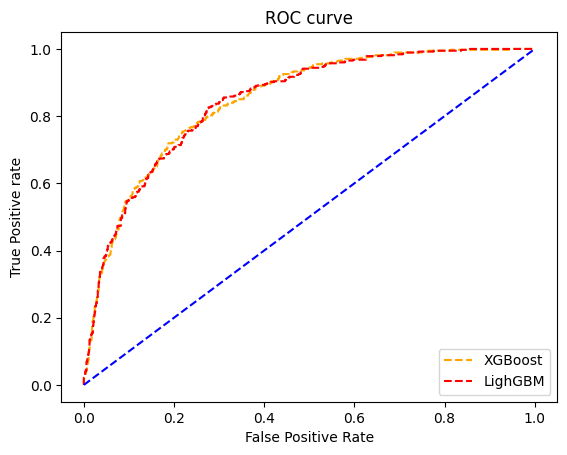

In [95]:
# plot roc curves
plt.plot(fpr_x, tpr_x, linestyle='--',color='orange', label='XGBoost')
plt.plot(fpr_l, tpr_l, linestyle='--',color='red', label='LighGBM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='lower right')
plt.show();

In [96]:
# auc scores
auc_score_xgb = roc_auc_score(y_test, probs_xgb)
auc_score_lgb = roc_auc_score(y_test, probs_lgb)

In [97]:
print("XGBoost AUC score :",np.round(auc_score_xgb,decimals = 2))
print("LightGBM AUC score :",np.round(auc_score_lgb,decimals = 2))
print("XGBoost Balanced Accuracy Score :",np.round(balanced_accuracy_score(y_test, y_pred_xgb),decimals = 2))
print("LightGBM Balanced Accuracy Score :",np.round(balanced_accuracy_score(y_test, y_pred_lgb),decimals = 2))

XGBoost AUC score : 0.85
LightGBM AUC score : 0.85
XGBoost Balanced Accuracy Score : 0.76
LightGBM Balanced Accuracy Score : 0.77


In [93]:
# As seen, XGBoost and LightGBM model very similiar performance. As LightGBM model is faster to train we

print("XGBoost Classification Report:")
print()
print(classification_report(y_test, y_pred_xgb, target_names=labels))
print("LightGBM Classification Report:")
print()
print(classification_report(y_test, y_pred_lgb, target_names=labels))

XGBoost Classification Report:

               precision    recall  f1-score   support

Did not leave       0.92      0.69      0.79      1035
         Left       0.49      0.83      0.62       374

     accuracy                           0.73      1409
    macro avg       0.70      0.76      0.70      1409
 weighted avg       0.80      0.73      0.74      1409

LightGBM Classification Report:

               precision    recall  f1-score   support

Did not leave       0.92      0.73      0.81      1035
         Left       0.52      0.82      0.63       374

     accuracy                           0.75      1409
    macro avg       0.72      0.77      0.72      1409
 weighted avg       0.81      0.75      0.76      1409



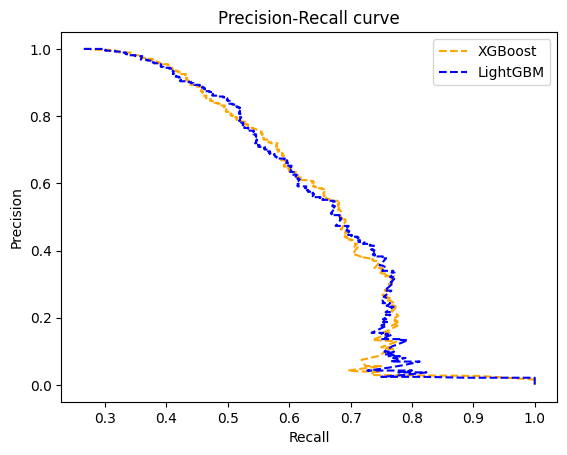

In [101]:
# roc curve for models
precision_xgb, recall_xgb, thresh_xgb = precision_recall_curve(y_test, probs_xgb, pos_label=1)
precision_lgb, recall_lgb, thresh_lgb = precision_recall_curve(y_test, probs_lgb, pos_label=1)

# plot roc curves
plt.plot(precision_xgb, recall_xgb, linestyle='--',color='orange', label='XGBoost')
plt.plot(precision_lgb, recall_lgb, linestyle='--',color='blue', label='LightGBM')

# title
plt.title('Precision-Recall curve')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.show();

**The XGBoost and LightGBM models exhibit very similar performance.**

1.XGBoost cross validation recall is 4% higher than LightGBM:

a) XGBoost model successfully identifies 84% of the customers who have left.

b) LightGBM model successfully identifies 81% of the customers who have left.

2.LightGBM model trains faster.

**Result : If we have sufficient computational power, we can choose XGBoost. However, if our computational resources are limited, opting for LightGBM would be a suitable alternative. In this case, we will proceed with the XGBoost model.**

# 10. SHAP : Model Interpretation

In [217]:
shap.initjs()

In [218]:
# Shap values
explainer = shap.Explainer(clf_xgb_tuned.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 1410it [00:32, 29.71it/s]                          


# 10.1 Waterfall Plot

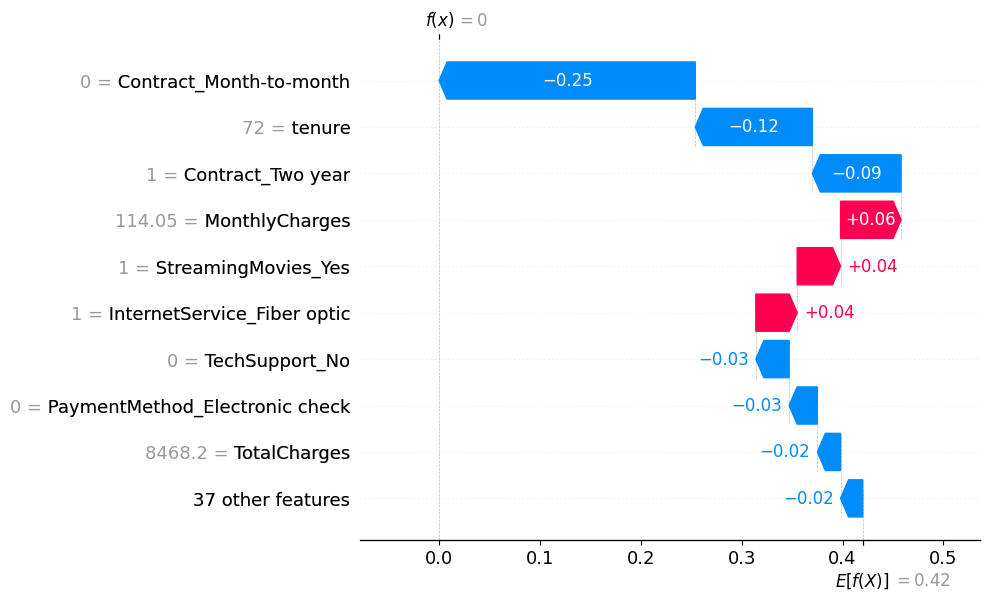

In [228]:
# Waterfall plot for first observation

#Interpretation : The waterfall plot indicates that when a customer does not have a month-to-month contract, 
#the logarithm of odds of churn decreases by 0.25. Moreover, customers who have a longer tenure with the company 
# are less likely to churn.
shap.plots.waterfall(shap_values[0])

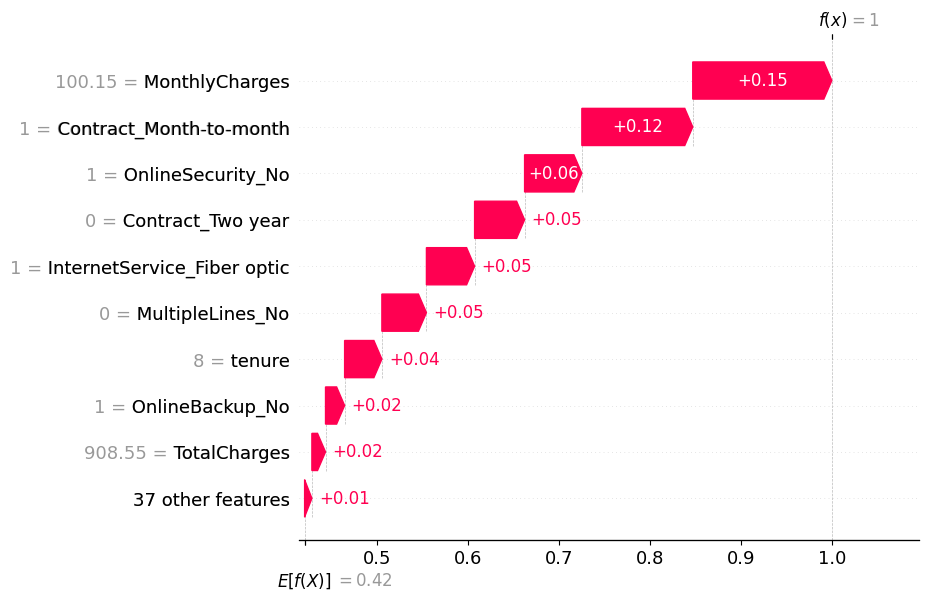

In [231]:
# Waterfall for second observation

#Interpretation : The waterfall plot reveals that if a customer pays more each month, 
#the logarithm of odds of churn increases by 0.15. Moreover, when a customer has a month-to-month contract, 
#the logarithm of odds of churn increases by 0.12


shap.plots.waterfall(shap_values[1])

# 10.2 Stacked Force Plot

In [232]:
shap.plots.force(shap_values[0:300])

# 10.3 Absolute Mean SHAP : It tells us , on average, how much each variable impacts the predicted churn probability

**As observed, the "contract_month-to-month" option has the most significant impact. This is logical because if a customer renews their contract on a monthly basis, they are more likely to switch to a different carrier in the following month.**

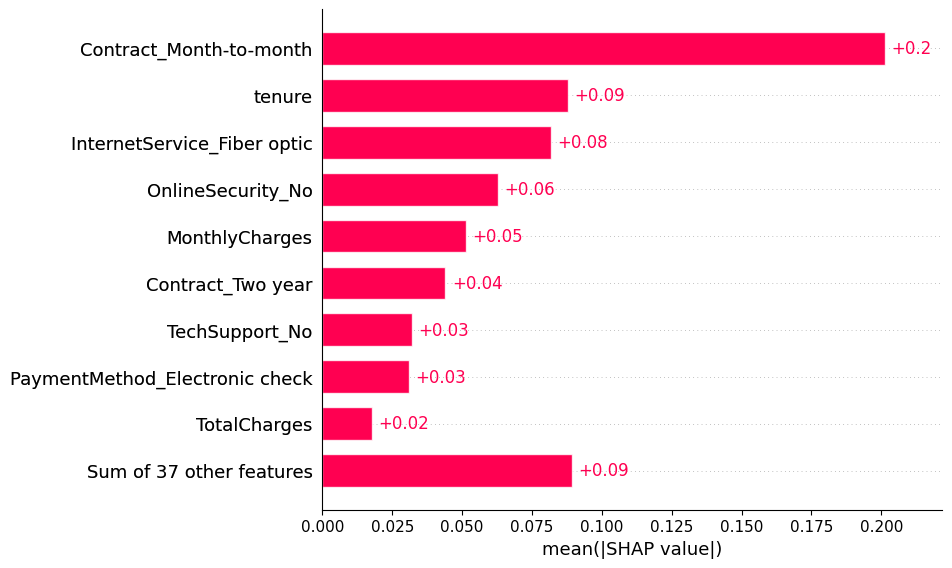

In [233]:
shap.plots.bar(shap_values)

In [234]:
# Check it manually
np.round(np.mean(np.abs(shap_values[:,"Contract_Month-to-month"].values)), decimals = 2)

0.2

In [235]:
# Check it manually
np.round(np.mean(np.abs(shap_values[:,"tenure"].values)), decimals = 2)

0.09

# 10.4 Beeswarm plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


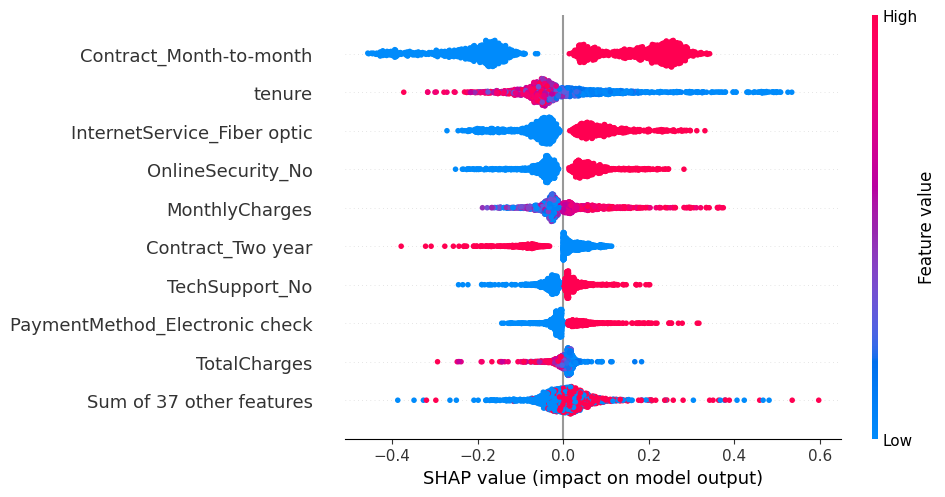

In [236]:
shap.plots.beeswarm(shap_values)

# 10.5 Dependence Plots

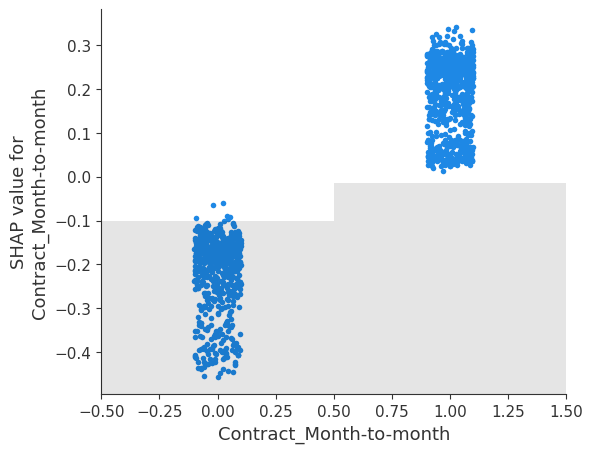

In [237]:
# For feature: Contract_Month-to-month
shap.plots.scatter(shap_values[:,"Contract_Month-to-month"])

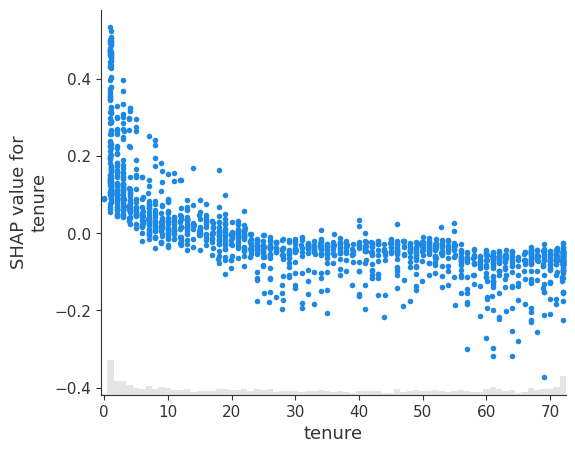

In [238]:
shap.plots.scatter(shap_values[:,"tenure"])